# Running PARC for clustering analysis of Covid-19 scRNA cells

### Introduction
Parc is a fast clustering algorithm designed to effectively cluster heterogeneity in large single cell data. We show how PARC enables downstream analysis on the recent dataset published by [Liao. et al (2020)](https://www.nature.com/articles/s41591-020-0901-9)

### Load Libraries

In [7]:
import matplotlib.pyplot as plt
import warnings
from numba.errors import NumbaPerformanceWarning
import numpy as np
import pandas as pd
import scanpy as sc
import parc
import harmonypy as hm
import seaborn as sns

### Load Data

The data is available on [GEO GSE145926](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926) with each of the 12 patients in a separate .h5 file. 
The result should be a matrix of shape (n_cells x n_genes) (108230, 33538).

In [181]:
datadir = "/home/shobi/Thesis/Data/Covid/GSE145926_RAW/"
file_batches = ['GSM4475051_C148_filtered_feature_bc_matrix.h5','GSM4475052_C149_filtered_feature_bc_matrix.h5','GSM4475053_C152_filtered_feature_bc_matrix.h5','GSM4475048_C51_filtered_feature_bc_matrix.h5','GSM4475049_C52_filtered_feature_bc_matrix.h5','GSM4339769_C141_filtered_feature_bc_matrix.h5','GSM4339770_C142_filtered_feature_bc_matrix.h5','GSM4339771_C143_filtered_feature_bc_matrix.h5','GSM4339772_C144_filtered_feature_bc_matrix.h5','GSM4475050_C100_filtered_feature_bc_matrix.h5','GSM4339773_C145_filtered_feature_bc_matrix.h5','GSM4339774_C146_filtered_feature_bc_matrix.h5']
patient_type =['S4','S5','S6','HC1','HC2','M1','M2','S2','M3','HC3','S1','S3']
patient_health = ['S','S','S','H','H','M','M','S','M','H','S','S']

for i in range(0,len(patient_type)):
    if i ==0:
        adata = sc.read_10x_h5('/home/shobi/Thesis/Data/Covid/GSE145926_RAW/'+file_batches[i])
        adata.obs['patient_type'] = [patient_type[i] for i_range in range(adata.shape[0])]
        adata.obs['patient_health'] = [patient_health[i] for i_range in range(adata.shape[0])]
        adata.var_names_make_unique()
        
    else:
        temp = sc.read_10x_h5('/home/shobi/Thesis/Data/Covid/GSE145926_RAW/'+file_batches[i] )
        temp.var_names_make_unique()
        temp.obs['patient_type'] = [patient_type[i] for i_range in range(temp.shape[0])]
        temp.obs['patient_health'] = [patient_health[i] for i_range in range(temp.shape[0])]
        adata = adata.concatenate(temp, join='inner') #we want the genes in common
   

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variab

### Filtering and pre-processing

Following the filters used by Liao et.al (2020) and removing cells with mitochondrial gene proportion > 0.1. 
After filtering the n_cells = 63753 and n_genes = 25668.

In [182]:
min_cells=3 
min_genes=200
max_genes = 6000
min_counts=1000
n_top_genes=2000
n_comps_pca= 50

sc.pp.filter_genes(adata, min_cells=min_cells)  # only consider genes expressed in more than min_cells
sc.pp.filter_cells(adata, min_genes=min_genes) #only consider cells with more than min_genes
sc.pp.filter_cells(adata,max_genes=max_genes) #only consider cells with less than max_cells
sc.pp.filter_cells(adata, min_counts=min_counts) #only consider cells with more than min_counts

mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1/ np.sum(adata.X, axis=1).A1
adata = adata[adata.obs.percent_mito < 0.1, :] #filter cells with high mito

adata.obs['n_counts'] = adata.X.sum(axis=1).A1 #add the total counts per cell as observations-annotation to adata

print('shape after filtering', adata.shape)

sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all' )# normalize with total UMI count per cell
sc.pp.log1p(adata)
adata.raw = adata
adata_beforeHVG =adata.copy()




Trying to set attribute `.obs` of view, making a copy.


shape after filtering (63753, 25668)


### Harmony PCA to integrate the batches

In [213]:
print('CD68' in adata.raw.var_names)

#select HVG
filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=n_top_genes, log=False ) # select highly-variable genes
print(filter_result, filter_result.gene_subset)

adata = adata[:, filter_result.gene_subset]  # subset the genes

sc.pp.scale(adata, max_value=5)  # scale to unit variance and shift to zero mean. Clip values exceeding standard deviation 10.
sc.tl.pca(adata, svd_solver='arpack', n_comps=n_comps_pca)

True


IndexError: index 1999 is out of bounds for axis 0 with size 1999

In [123]:
df_meta = pd.DataFrame()
df_meta['patient_type'] = adata.obs['patient_type']
harmony_out = hm.run_harmony(adata.obsm['X_pca'], df_meta, 'patient_type')
res = harmony_out.Z_corr.T
print('size of harmony corrected output', res.shape, type(res))


2020-07-13 14:44:37,211 - harmonypy - INFO - Iteration 1 of 10
2020-07-13 14:44:51,642 - harmonypy - INFO - Iteration 2 of 10
2020-07-13 14:45:05,951 - harmonypy - INFO - Iteration 3 of 10
2020-07-13 14:45:20,445 - harmonypy - INFO - Converged after 3 iterations


size of harmony corrected output (63753, 50) <class 'numpy.ndarray'>


### Run PARC clustering and get PARC-UMAP embedding 

We construct the UMAP embedding my providing UMAP that KNN graph constructed in PARC. the PARC-UMAP implementation is runtime efficient, and has significantly lower RAM usage 

input data has shape 63753 (samples) x 50 (features)
knn struct was not available, so making one
commencing local pruning based on Euclidean distance metric at 3 s.dev above mean
commencing global pruning
commencing community detection
partition type MVP


... storing 'parc' as categorical
... storing 'health_parc' as categorical


list of cluster labels and populations 26 [(0, 10325), (1, 10216), (2, 8257), (3, 7178), (4, 3541), (5, 3186), (6, 2807), (7, 2678), (8, 2663), (9, 2442), (10, 1460), (11, 1127), (12, 1113), (13, 1074), (14, 1070), (15, 882), (16, 875), (17, 799), (18, 726), (19, 526), (20, 226), (21, 189), (22, 156), (23, 138), (24, 54), (25, 45)]
time elapsed 44.4 seconds
Plot cluster average expression of marker genes


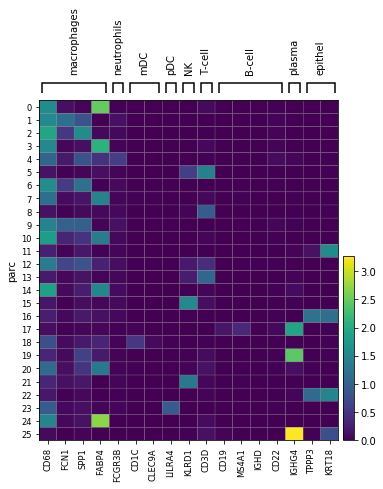

a,b, spread, dist 1.576943460405378 0.8950608781227859 1.0 0.1
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
completed embedding


In [209]:
p = parc.PARC(res, random_seed=42)
p.run_PARC()
adata.obs['parc'] = [str(i) for i in p.labels]

marker_genes = {"macrophages": ['CD68','FCN1','SPP1','FABP4'], "neutrophils": ['FCGR3B'],
                "mDC": ['CD1C', 'CLEC9A'], "pDC": ['LILRA4'],
                "NK": ['KLRD1'], 'T-cell': ['CD3D'], 'B-cell': ['CD19','MS4A1','IGHD', 'CD22'], 'plasma': ['IGHG4'], #CD19 doesnt show up for B
                'epithel': ['TPPP3', 'KRT18']}

print('Plot cluster average expression of marker genes')
ax_mat = sc.pl.matrixplot(adata, marker_genes, groupby='parc')
graph = p.knngraph_full()
embedding= p.run_umap_hnsw(res, graph, random_state = 1)
print('completed embedding')



True
ENSG00000129226 in varnames False
Cd68 in varnames False
SCARD1 in varnames False
GP110 in varnames False
LAMP4 in varnames False
Gp110 in varnames False
SPP1 in varnames True
Plot cluster average expression of marker genes


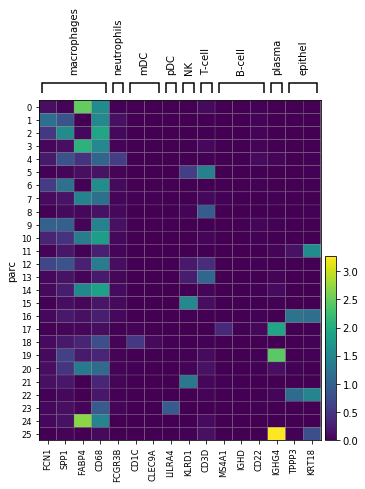

In [210]:
print('CD68' in adata.raw.var_names)
marker_genes = { "macrophages": ['FCN1','SPP1','FABP4','CD68'],"neutrophils": ['FCGR3B'],
                "mDC": ['CD1C', 'CLEC9A'], "pDC": ['LILRA4'],
                "NK": ['KLRD1'], 'T-cell': ['CD3D'], 'B-cell': ['MS4A1','IGHD', 'CD22'], 'plasma': ['IGHG4'], #CD19 doesnt show up for B
                'epithel': ['TPPP3', 'KRT18']} #"macrophages": ['FCN1','SPP1','FABP4','CD68'],

for i in ['ENSG00000129226','Cd68','SCARD1','GP110','LAMP4','Gp110','SPP1']:
    print(i, 'in varnames', i in adata.var_names)
print('Plot cluster average expression of marker genes')
ax_mat = sc.pl.matrixplot(adata, marker_genes, groupby='parc')


### Marker gene expression of macrophage and non-macrophage clusters 

Compute average cluster level gene expressions and sort those with high cd68 as macrophage clusters 
Identify the cluster composition in terms of H, M and S to label each cluster as predominantly H, M or S

/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
Trying to set attribute `.obs` of view, making a copy.
... storing 'health_parc' as categorical


categories: H0, H3, H7, etc.
var_group_labels: Healthy, Moderate, Severe


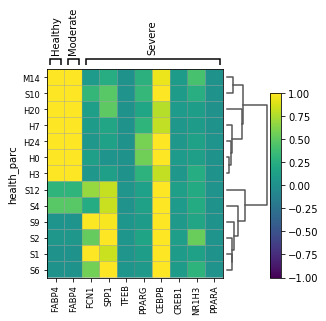

Trying to set attribute `.obs` of view, making a copy.
... storing 'health_parc' as categorical


categories: H18, M5, S8, etc.
var_group_labels: mDC, pDC, NK, etc.


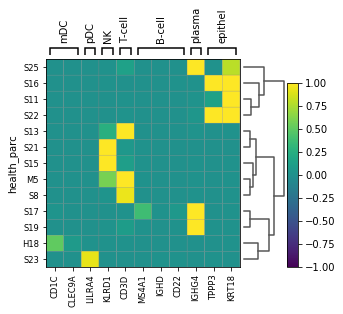

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[3.52, 0.8, 0.2])

In [211]:
clustermap_marker_ = {'Group 1': ['S100A8', 'FCN1','CD14'],'Group 2':['CCL2', 'CCL3', 'CXCL10'],'Group 1-2':['STAT1','STAT2'],'Group 3':['SPP1','A2M', 'GPR183','CCL13','CREB1','TFEB','NR1H3', 'PPARA'],'Group 4':['FABP4','APOC1', 'MARCO','PPARG', 'CEBPB'] }
clustermap_marker_genes = {'Healthy':['FABP4'], 'Moderate': ['FABP4'], 'Severe':['FCN1','SPP1','TFEB','PPARG', 'CEBPB','CREB1','NR1H3', 'PPARA']}
#marker genes for non-macrophage clusters 
marker_genes = { 
                "mDC": ['CD1C', 'CLEC9A'], "pDC": ['LILRA4'],
                "NK": ['KLRD1'], 'T-cell': ['CD3D'], 'B-cell': ['MS4A1','IGHD', 'CD22'], 'plasma': ['IGHG4'], #CD19 doesnt show up for B
                'epithel': ['TPPP3', 'KRT18']}

adata.obs['macrophage'] = adata.raw[:, 'CD68'].X



df_adata = pd.DataFrame(adata.X, columns = [i for i in list(adata.var_names)])
df_adata['parc'] = [i for i in adata.obs['parc']]
df_adata['cd68'] = [i for i in adata.obs['macrophage']] #CD68 is not in the filtered HVG genes, but in adata.RAW 

df_adata = df_adata.groupby('parc',as_index=False).mean()
df_adata['macrophage'] = df_adata['cd68']>(np.mean(df_adata['cd68']+0.2*np.std(df_adata['cd68'])))

macrophage_cluster_list = df_adata[df_adata['macrophage']==True]['parc'].values

patient_health_list = [i for i in adata.obs['patient_health']]
parc_health = np.empty([len(p.labels), 1], dtype=object)
health_dict = {"H":[],"S":[],"M":[]}
for i in set(p.labels):
    loc_i = np.where(np.asarray(p.labels)==i)[0]
    ll= list(np.asarray(patient_health_list)[loc_i])
    mode_i = max(set(ll), key=ll.count)
  
    if mode_i == 'S':
        parc_health[loc_i] = 'S'+str(i)
        health_dict["S"].append(i)
    elif mode_i == 'M':
        parc_health[loc_i] = 'M'+str(i)
        health_dict["M"].append(i)
    elif mode_i == 'H':
        parc_health[loc_i] = 'H'+str(i)
        health_dict["H"].append(i)

parc_health = list(parc_health.flatten())

adata.obs['health_parc'] = [str(i) for i in parc_health]
macrophage_cluster_bool = []
for i in p.labels:
    if str(i) in macrophage_cluster_list: macrophage_cluster_bool.append(True)
    else: macrophage_cluster_bool.append(False)

adata.obs['macro_clus'] = macrophage_cluster_bool
adata_macro = adata[adata.obs['macro_clus']==True]
adata_not_macro = adata[adata.obs['macro_clus']!=True]

new_health_parc = [i for i in adata_macro.obs['health_parc']]

sc.pl.matrixplot(adata_macro, clustermap_marker_genes, groupby='health_parc', vmax=1, vmin=-1, dendrogram=True)
sc.pl.matrixplot(adata_not_macro,marker_genes, groupby='health_parc', vmax=1, vmin=-1, dendrogram=True)


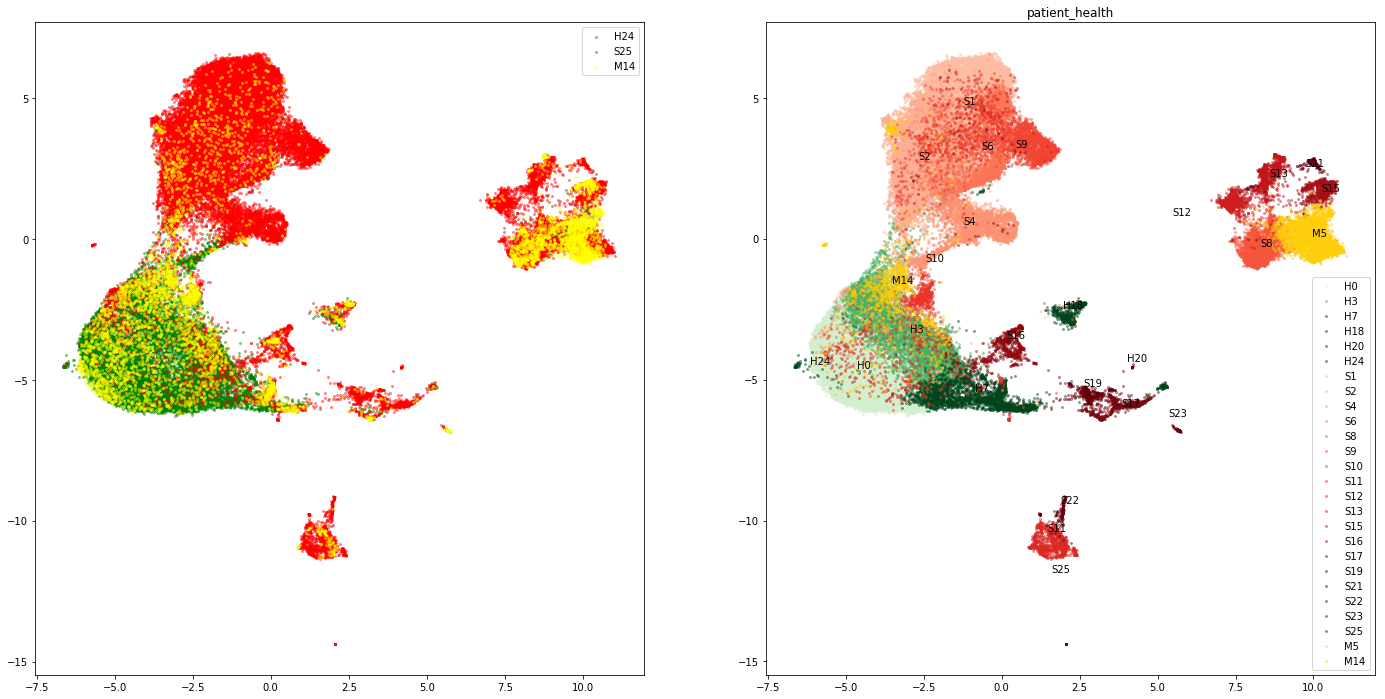

In [208]:
color_views = ['FCN1','SPP1','FABP4']

fig, axs = plt.subplots(1,2 ,figsize=(24,12))


color_views_categ = ['patient_health', 'parc']
color_dict = {"H":'Green',"S":'Red',"M":'Yellow'}
import matplotlib.colors as colors
import matplotlib.cm as cmx

    
cmap = plt.get_cmap('Wistia')
new_Yellows = colors.LinearSegmentedColormap.from_list('name', cmap(np.linspace(0.1, 0.4, 100)))

cmap = plt.get_cmap('Reds')
new_Reds = colors.LinearSegmentedColormap.from_list('name', cmap(np.linspace(0.2, 1, 100)))

cmap = plt.get_cmap('Greens')
new_Greens = colors.LinearSegmentedColormap.from_list('name', cmap(np.linspace(0.2, 1, 100)))
dict_color = {}
for key in health_dict:
    uniq = health_dict[key]
    z = range(1,len(uniq))
    cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    if key=='S': scalarMap = cmx.ScalarMappable(norm=cNorm, cmap= new_Reds)
    elif key =='H':scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=new_Greens)
    elif key =='M':scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=new_Yellows)
    for i in uniq:

        indx = adata.obs['parc'] == str(i)
        axs[1].scatter(embedding[indx,0], embedding[indx,1], color =scalarMap.to_rgba(i), label=key+str(i), alpha=0.4, s =4)
        axs[1].set_title(color_views_categ[i_ax])
        axs[1].text(np.mean(embedding[indx,0]),np.mean(embedding[indx,1]),key+str(i))
        axs[1].legend()
    indx = adata.obs['patient_health']== key
    axs[0].scatter(embedding[indx,0], embedding[indx,1], color =color_dict[key], label=key+str(i), alpha=0.4, s =4)
    axs[0].legend()
plt.show()


### Expression of macrophage marker genes

/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


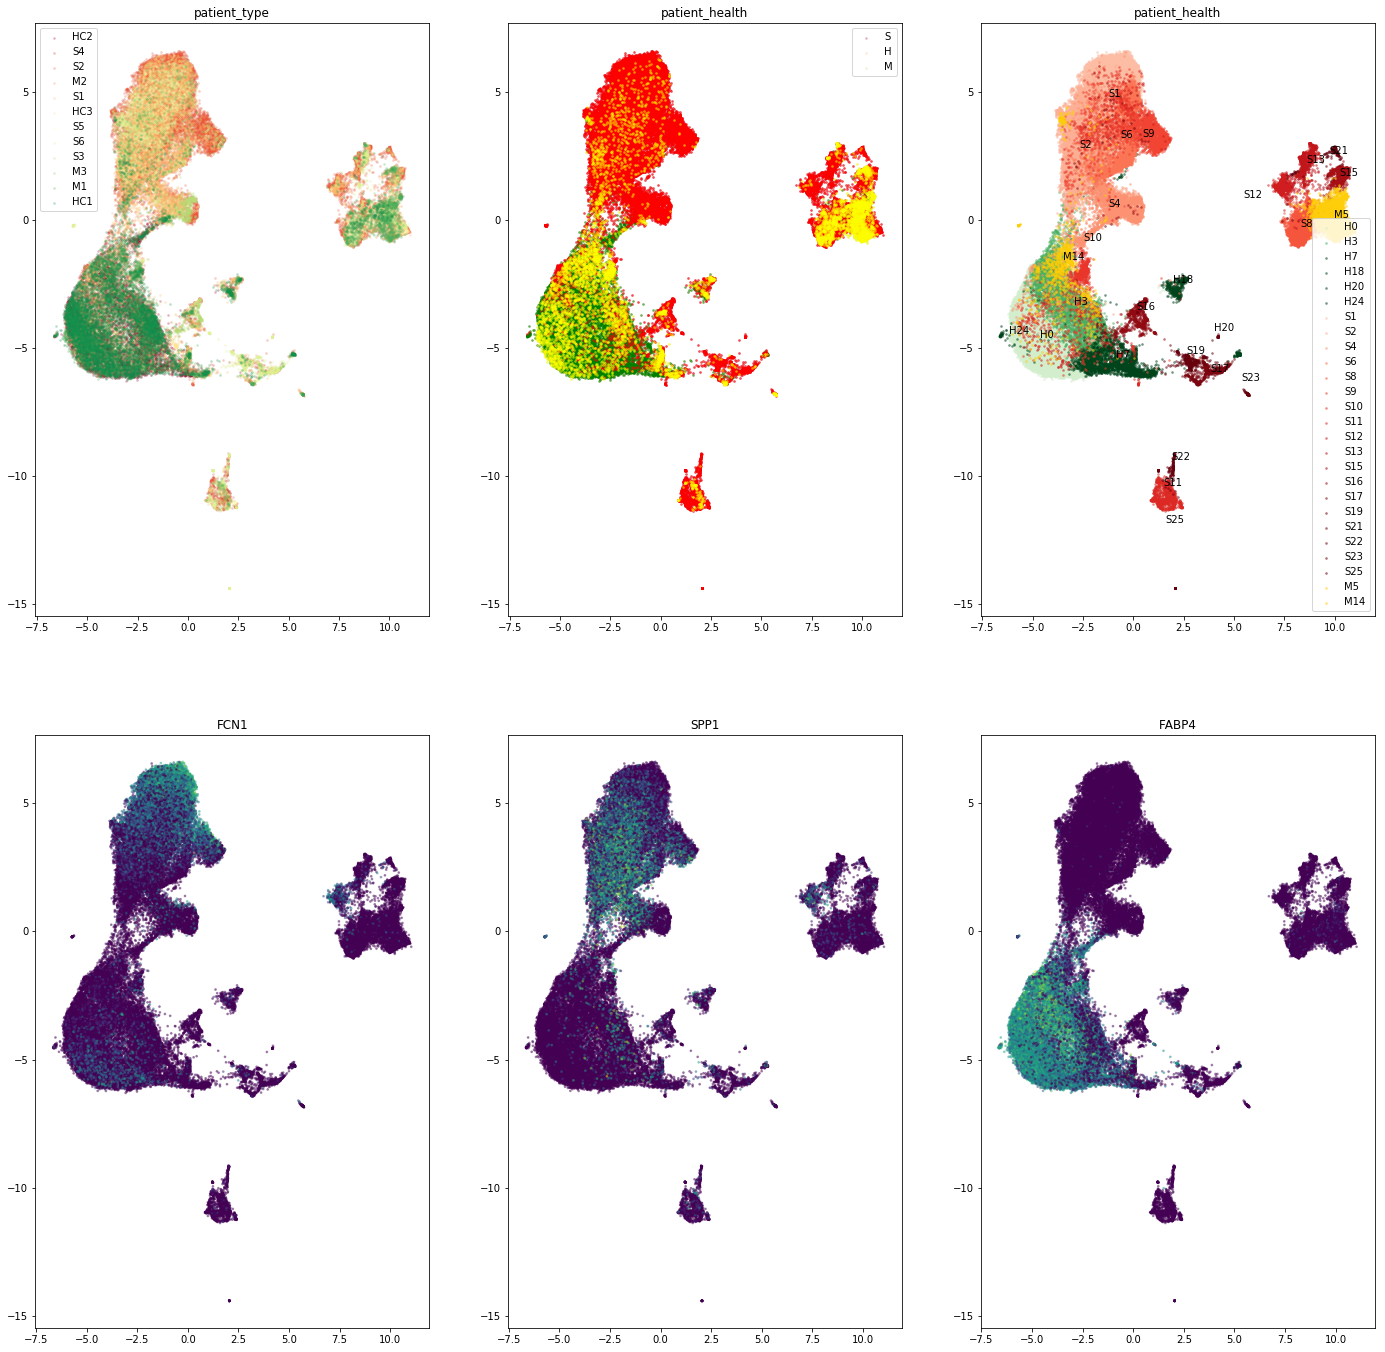

In [199]:
color_views = ['FCN1','SPP1','FABP4']

fig, axs = plt.subplots(2,3 ,figsize=(24,24))
for i in range(3):
    axs[1,i].scatter(embedding[:,0], embedding[:,1], c = adata[:,color_views[i]].X.flatten(), alpha=0.4, s =3)
    axs[1,i].set_title(color_views[i])

color_views_categ = ['patient_type', 'patient_health', 'parc']
color_dict = {"H":'Green',"S":'Red',"M":'Yellow'}
import matplotlib.colors as colors
import matplotlib.cm as cmx
for i_ax in range(2):
    uniq = list(set(adata.obs[color_views_categ[i_ax]]))
    # Set the color map to match the number of species
    z = range(1,len(uniq))
    #hot = plt.get_cmap('RdYlBu')
    cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='RdYlGn')
    # Plot each species
    for i in range(len(uniq)):
        indx = adata.obs[color_views_categ[i_ax]] == uniq[i]
        axs[0,i_ax].scatter(embedding[indx,0], embedding[indx,1], color =scalarMap.to_rgba(i), label=uniq[i], alpha=0.2, s =3)
    axs[0,i_ax].set_title(color_views_categ[i_ax])
    axs[0,i_ax].legend()
    
cmap = plt.get_cmap('Wistia')
new_Yellows = colors.LinearSegmentedColormap.from_list('name', cmap(np.linspace(0.1, 0.4, 100)))

cmap = plt.get_cmap('Reds')
new_Reds = colors.LinearSegmentedColormap.from_list('name', cmap(np.linspace(0.2, 1, 100)))

cmap = plt.get_cmap('Greens')
new_Greens = colors.LinearSegmentedColormap.from_list('name', cmap(np.linspace(0.2, 1, 100)))
dict_color = {}
for key in health_dict:
    uniq = health_dict[key]
    z = range(1,len(uniq))
    cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    if key=='S': scalarMap = cmx.ScalarMappable(norm=cNorm, cmap= new_Reds)
    elif key =='H':scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=new_Greens)
    elif key =='M':scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=new_Yellows)
    for i in uniq:

        indx = adata.obs['parc'] == str(i)
        axs[0,2].scatter(embedding[indx,0], embedding[indx,1], color =scalarMap.to_rgba(i), label=key+str(i), alpha=0.4, s =3)
        axs[0,2].set_title(color_views_categ[i_ax])
        axs[0,2].text(np.mean(embedding[indx,0]),np.mean(embedding[indx,1]),key+str(i))
        axs[0,2].legend()
    indx = adata.obs['patient_health']== key
    axs[0,1].scatter(embedding[indx,0], embedding[indx,1], color =color_dict[key], label=key+str(i), alpha=0.4, s =3)
plt.show()
